In [26]:
import pandas as pd
import numpy as np
import folium
from shapely.geometry import LineString

In [2]:
path_ano = "../data/preliminary_phase/output_anon_data_IDP/"
path_ref = "../data/preliminary_phase/output_ref_data_IDP/"

In [3]:
reg_ano = np.concatenate([np.load(f"{path_ano}/cell_traj_d1.npy"), np.load(f"{path_ano}/cell_traj_d2.npy")], axis=1)
reg_ref = np.concatenate([np.load(f"{path_ref}/cell_traj_d1.npy"), np.load(f"{path_ref}/cell_traj_d2.npy")], axis=1)

coo_ano = np.concatenate([np.load(f"{path_ano}/lat_lng_traj_d1.npy"), np.load(f"{path_ano}/lat_lng_traj_d2.npy")], axis=1)
coo_ref = np.concatenate([np.load(f"{path_ref}/lat_lng_traj_d1.npy"), np.load(f"{path_ref}/lat_lng_traj_d2.npy")], axis=1)

In [4]:
np.intersect1d(reg_ref[0], reg_ano[0])

array([259, 267, 390, 427, 432, 562])

In [5]:
np.unique(reg_ano[0], return_counts=True)[0][np.unique(reg_ano[0], return_counts=True)[1] >1]

array([398, 425, 427, 454])

In [6]:
h = np.zeros(reg_ano.shape[0])
for i in range(reg_ano.shape[0]):
    h[i] = np.intersect1d(reg_ref[i], reg_ano[i]).shape[0]

In [7]:
h

array([6., 2., 8., ..., 7., 6., 0.])

In [8]:
import shapely.geometry as geom

rectangle = geom.LineString(coo_ref.reshape(-1, 2)).bounds
print(rectangle)

(35.6515625, 139.68187500000002, 35.7484375, 139.79812500000003)


In [11]:
import pywraps2 as s2

# create a rect in s2
region_rect = s2.S2LatLngRect(
    s2.S2LatLng.FromDegrees(rectangle[0], rectangle[1]),
    s2.S2LatLng.FromDegrees(rectangle[2], rectangle[3]))

# ask s2 to create a cover of this rect
coverer = s2.S2RegionCoverer()
coverer.set_min_level(11)
coverer.set_max_level(13)
coverer.set_max_cells(20)
covering = coverer.GetCovering(region_rect)
print(len([c.ToToken() for c in covering]))

# create a map
map_osm = folium.Map(location=[rectangle[0], rectangle[1]],zoom_start=12, tiles='Stamen Toner')

# get vertices from rect to draw them on map
rect_vertices = []
for i in [0, 1, 2, 3, 0]:
    vertex = region_rect.GetVertex(i)
    rect_vertices.append([vertex.lat().degrees(), vertex.lng().degrees()])
    
# draw the cells
style_function = lambda x: {'weight': 1, 'fillColor':'#eea500'}
for cellid in covering:
    cell = s2.S2Cell(cellid)
    vertices = []
    for i in range(0, 4):
        vertex = cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append([latlng.lng().degrees(),
                         latlng.lat().degrees()])
        
    gj = folium.GeoJson({ "type": "Polygon", "coordinates": [vertices]}, style_function=style_function)
    gj.add_children(folium.Popup(cellid.ToToken()))
    gj.add_to(map_osm)
    
# warning PolyLine is lat,lng based while GeoJSON is not
ls = folium.PolyLine(rect_vertices, color='red', weight=2)
ls.add_children(folium.Popup("shape"))
ls.add_to(map_osm)
    
map_osm

20


/home/drayer34/.virtualenvs/pwscup19/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/home/drayer34/.virtualenvs/pwscup19/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [12]:
folium.PolyLine(coo_ref[14]).add_to(map_osm)
folium.PolyLine(coo_ano[14], color="red").add_to(map_osm)
map_osm

In [13]:
import skmob

In [14]:
df_ano = pd.read_csv("../data/preliminary_phase/AnonData_011/pubtrace_team_011_data01_IDP.csv")
reg_info = pd.read_csv("../data/preliminary_phase/OrgData(Anony-Pre)_011/info_region.csv")
time_info = pd.read_csv("../data/preliminary_phase/OrgData(Anony-Pre)_011/info_time.csv")
df_ano = df_ano.merge(reg_info, on="reg_id").drop(["x_id", "y_id", "hospital"], axis=1).merge(time_info, on="time_id")

In [15]:
df_ano["timestamp"] = df_ano[["day", "hour", "min"]].apply(
    lambda x: pd.datetime(2019, 3, x["day"], x["hour"], x["min"]),
    axis=1)

In [16]:
df_ano.drop(["day", "hour", "min", "ref/org"], axis=1, inplace=True)

In [17]:
tdf_ano = skmob.TrajDataFrame(df_ano, user_id="user_id", latitude="y(center)", longitude="x(center)", datetime="timestamp")

In [18]:
from skmob.preprocessing import detection, clustering
dtdf_ano = detection.stops(tdf_ano, minutes_for_a_stop=20)

In [19]:
ctdf_ano = clustering.cluster(dtdf_ano, cluster_radius_km=0.1)

In [20]:
ctdf_ano.cluster.unique().shape

(39,)

In [21]:
df_ano.reg_id.unique().shape

(1024,)

In [22]:
a = ctdf_ano.groupby("uid")["cluster"].value_counts()[ctdf_ano.groupby("uid")["cluster"].value_counts() > 1]

In [23]:
a.index.get_level_values(1).value_counts()

0    1948
1    1788
2    1482
3    1079
4     669
5     351
6     177
7      60
8      19
9       4
Name: cluster, dtype: int64

In [24]:
from skmob.preprocessing import filtering

filtered = filtering.filter(tdf_ano, max_speed_kmh=5)

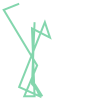

In [27]:
LineString(np.array(list(filtered.sort_values("time_id").groupby("uid")["lat", "lng"].apply(lambda x: list(zip(x.lat, x.lng)))))[1]).simplify(0.01, preserve_topology=False)

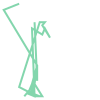

In [28]:
LineString(np.array(list(filtered.sort_values("time_id").groupby("uid")["lat", "lng"].apply(lambda x: list(zip(x.lat, x.lng)))))[1]).simplify(0)

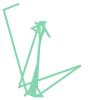

In [29]:
LineString(coo_ano[1])

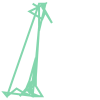

In [30]:
coo_org = np.concatenate(
    [np.load("../data/preliminary_phase/output_org_data_IDP/lat_lng_traj_d1.npy", allow_pickle=True),
    np.load("../data/preliminary_phase/output_org_data_IDP/lat_lng_traj_d2.npy", allow_pickle=True)],
    axis=1)
LineString(coo_org[1])

In [31]:
filtered

,uid,time_id,reg_id,lat,lng,datetime
0,1,41,398,35.689062,139.730625,2019-03-03 08:00:00
1,1,43,37,35.654687,139.696875,2019-03-03 09:00:00
2,1,44,3,35.651562,139.689375,2019-03-03 09:30:00
3,1,45,71,35.657812,139.704375,2019-03-03 10:00:00
4,1,47,274,35.676563,139.745625,2019-03-03 11:00:00
5,1,48,370,35.685937,139.745625,2019-03-03 11:30:00
6,1,49,433,35.692188,139.741875,2019-03-03 12:00:00
7,1,50,427,35.692188,139.719375,2019-03-03 12:30:00
8,1,51,390,35.689062,139.700625,2019-03-03 13:00:00
9,1,52,394,35.689062,139.715625,2019-03-03 13:30:00


### Multi decision 

In [32]:
path_x = "/home/drayer34/Documents/phD/projects/pwscup2019/data/preliminary_phase/output_org_data_IDP/"
cell_ori = np.concatenate([np.load(f"{path_x}/cell_traj_d1.npy"), np.load(f"{path_x}/cell_traj_d2.npy")], axis=1)
latlng_ori = np.concatenate([np.load(f"{path_x}/lat_lng_traj_d1.npy"), np.load(f"{path_x}/lat_lng_traj_d2.npy")], axis=1)

In [33]:
a = reg_ano[:, [17, 18, 19, 37, 38, 39]]
b = reg_ref[:, [17, 18, 19, 37, 38, 39]]
c = cell_ori[:, [17, 18, 19, 37, 38, 39]]

In [34]:
res = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        for k in range(b.shape[1]):
            if a[i][j] == b[i][k]:
                res[i] += 1

In [35]:
np.count_nonzero(res)/2000

0.1565

In [36]:
np.random.shuffle(b)

In [37]:
res = np.zeros(a.shape[0])
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        for k in range(b.shape[1]):
            if a[i][j] == b[i][k]:
                res[i] += 1

In [38]:
np.count_nonzero(res)/2000

0.05

In [39]:
from numba import njit

@njit
def end_compare(arr1, arr2):
    assert arr1.ndim == 1, "arr1 should be 1d"
    assert arr2.ndim == 1, "arr2 should be 1d"
    res = 0
    for i in range(arr1.shape[0]):
        for j in range(arr2.shape[0]):
            if arr1[i] == arr2[j]:
                res += 1
    return res

In [40]:
from scipy.spatial.distance import cdist

res_all = cdist(b, c, end_compare)

In [41]:
np.count_nonzero(res_all.diagonal() == res_all.max(axis=1))/2000

0.003

In [42]:
res_all.diagonal()[res_all.diagonal()>4].shape

(2,)

In [43]:
id_cache1 = 404
id_cache2 = 404

In [44]:
import pywraps2 as s2

# create a rect in s2
region_rect = s2.S2LatLngRect(
    s2.S2LatLng.FromDegrees(rectangle[0], rectangle[1]),
    s2.S2LatLng.FromDegrees(rectangle[2], rectangle[3]))

# create a map
map_osm = folium.Map(location=[rectangle[0], rectangle[1]],zoom_start=12, tiles='Stamen Toner')

# get vertices from rect to draw them on map
rect_vertices = []
for i in [0, 1, 2, 3, 0]:
    vertex = region_rect.GetVertex(i)
    rect_vertices.append([vertex.lat().degrees(), vertex.lng().degrees()])
    
# warning PolyLine is lat,lng based while GeoJSON is not
ls = folium.PolyLine(rect_vertices, color='red', weight=2)
ls.add_children(folium.Popup("shape"))
ls.add_to(map_osm)

/home/drayer34/.virtualenvs/pwscup19/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [45]:
folium.PolyLine(latlng_ori[id_cache1+123][20:40], color="red").add_to(map_osm)
folium.PolyLine(latlng_ori[id_cache1+123][0:20], color="green").add_to(map_osm)
folium.PolyLine(coo_ref[id_cache2+123][20:40]).add_to(map_osm)
folium.PolyLine(coo_ref[id_cache2+123][0:20], color="orange").add_to(map_osm)
map_osm

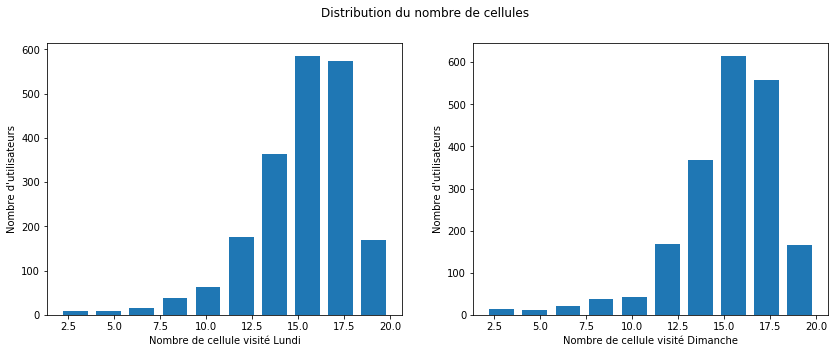

In [68]:
import matplotlib.pyplot as plt

@njit
def histogram_nb_visit(arr):
    assert arr.ndim == 2
    res = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        res[i] = np.unique(arr[i]).shape[0]
    return res

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution du nombre de cellules')
ax1.hist(histogram_nb_visit(cell_ori[:, :20]), rwidth=0.75)
ax1.set_xlabel("Nombre de cellule visité Lundi")
ax1.set_ylabel("Nombre d'utilisateurs")
ax2.hist(histogram_nb_visit(cell_ori[:, 20:]), rwidth=0.75)
ax2.set_xlabel("Nombre de cellule visité Dimanche")
ax2.set_ylabel("Nombre d'utilisateurs")
plt.show()

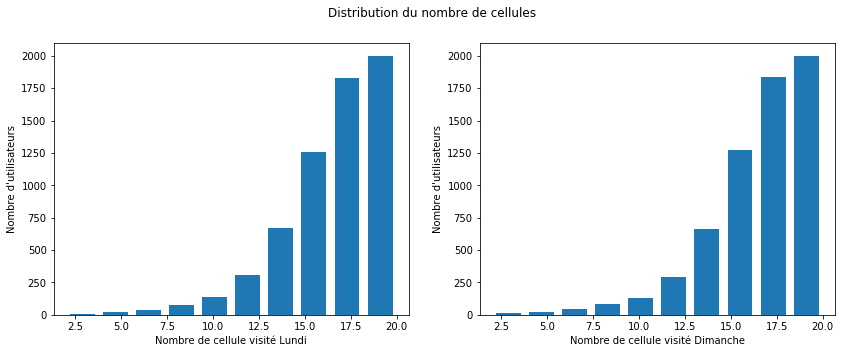

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribution du nombre de cellules')
ax1.hist(histogram_nb_visit(cell_ori[:, :20]), rwidth=0.75, cumulative=True)
ax1.set_xlabel("Nombre de cellule visité Lundi")
ax1.set_ylabel("Nombre d'utilisateurs")
ax2.hist(histogram_nb_visit(cell_ori[:, 20:]), rwidth=0.75, cumulative=True)
ax2.set_xlabel("Nombre de cellule visité Dimanche")
ax2.set_ylabel("Nombre d'utilisateurs")
plt.show()

In [126]:
from distance_benchmark import compute_pfipf

pfipf_reg_ano = compute_pfipf(reg_ano, 1024, 2000)
pfipf_reg_ref = compute_pfipf(reg_ref, 1024, 2000)

versus = cdist(pfipf_reg_ano, pfipf_reg_ref, metric="cosine")

pfipf_reg_ano[pfipf_reg_ano >= 1] = 1
pfipf_reg_ref[pfipf_reg_ref >= 1] = 1

In [150]:
df = pd.DataFrame(versus.argmin(axis=1)+1, columns=["user_id"])
df.index = df.index +1
df.reset_index(inplace=True)

In [153]:
df[df["index"] == df["user_id"]]

,index,user_id
11,12,12
14,15,15
40,41,41
49,50,50
57,58,58
77,78,78
158,159,159
218,219,219
260,261,261
299,300,300


In [138]:
versus[0].argmin()

671

In [147]:
versus

array([[0.88274138, 0.88029486, 1.        , ..., 1.        , 0.90273194,
        0.90036601],
       [0.69237486, 0.93879836, 1.        , ..., 0.91692011, 0.89668296,
        0.98816732],
       [1.        , 1.        , 0.85686465, ..., 1.        , 0.98893028,
        0.95884212],
       ...,
       [0.9601503 , 1.        , 0.98963261, ..., 0.81014928, 1.        ,
        0.97778187],
       [0.96774983, 0.97709808, 0.98453552, ..., 1.        , 0.7459095 ,
        0.9806729 ],
       [0.92972224, 0.98912806, 1.        , ..., 0.92903808, 1.        ,
        1.        ]])